In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from itertools import chain
import json
from json import JSONDecodeError
import seaborn as sns
from scipy.stats import linregress
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


def load_result(path):
    path = Path(path)
    try:
        with open(path / "results.json") as f:
            results = json.load(f)
        with open(path / "config.json") as f:
            config = json.load(f)
    except (FileNotFoundError, JSONDecodeError) as e:
        if isinstance(e, JSONDecodeError):
            print(f"Error decoding {path}: {e}")
        return
    
    if config["reporter"]["method"] == "ModularSftReporter":
        stages_cfg = config["reporter"]["stages"]
        weak_compute = sum(stage["num_weak_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        oracle_compute = sum(stage["num_oracle_nonunique"] * stage["train_args"]["num_train_epochs"] for stage in stages_cfg)
        total_compute = weak_compute + oracle_compute
    else:
        weak_compute, oracle_compute, total_compute = np.nan, np.nan, np.nan

    logodds = np.array(results["calibrated_logodds"])
    labels = np.array(results["gt_soft_labels"]) > 0.5
    thresh = np.quantile(logodds, labels.mean())
    calibrated_acc = ((logodds > thresh) == labels).mean()

    num_weak = results["reporter"]["num_weak"]
    num_oracle = results["reporter"]["num_oracle"]
    num_weak_nonunique = results["reporter"]["num_weak_nonunique"]
    num_oracle_nonunique = results["reporter"]["num_oracle_nonunique"]
    
    seed = int(path.name.split("_")[-1].split("s")[-1])
    sweep_name = "_".join(path.name.split("_")[3:-1])
    return {
        "auroc": results["auroc"],
        "acc": results["acc"],
        "calibrated_acc": calibrated_acc,
        "model_name": config["model"]["name"],
        "num_oracle": num_oracle,
        "num_weak": num_weak,
        "num_oracle_nonunique": num_oracle_nonunique,
        "num_weak_nonunique": num_weak_nonunique,
        "weak_compute": weak_compute,
        "oracle_compute": oracle_compute,
        "total_compute": total_compute,
        "seed": seed,
        "ds_name": path.parent.name,
        "sweep_name": sweep_name,
        "path": str(path),
    }


def get_results_df(ds_names=None, sweep_names=None):
    if sweep_names is not None:
        patterns = [f"nw=*_{sweep_name}_s*" for sweep_name in sweep_names]
    else:
        patterns = [f"nw=*_*_s*"]
    results = []
    if ds_names is None:
        ds_names = [d.name for d in Path("results").iterdir() if d.is_dir()]
    for ds_name in ds_names:
        for subdir in chain(*[Path(f"results/{ds_name}").glob(pattern) for pattern in patterns]):
            try:
                if result := load_result(subdir):
                    results.append(result)
            except Exception as e:
                continue
    results_df = pd.DataFrame(results)
    results_df.set_index(["ds_name", "model_name", "sweep_name"], inplace=True, drop=False)
    return results_df


def find_result_by_n(results_df, n_weak, n_oracle, run_name, atol=0., rtol=0., verbose=True, metric="acc"):
    curr_df = results_df.xs(run_name, level=['ds_name', 'model_name', 'sweep_name'])
    curr_df = curr_df[np.isclose(curr_df["num_oracle"], n_oracle, atol=atol, rtol=rtol)]
    curr_df = curr_df[np.isclose(curr_df["num_weak"], n_weak, atol=atol, rtol=rtol)]
    if len(curr_df) == 0:
        if verbose:
            print(f"WARNING: {run_name} has no results for ({n_weak}, {n_oracle})")
        return None, None, 0
    # print(curr_df["seed"].values.tolist())
    return curr_df[metric].mean(), curr_df[metric].std(), len(curr_df)

In [2]:
base_ds_names = [
    "boolq",
    "hellaswag",
    "sciq",
    "cola",
    "cosmos_qa",
    "quail",
    "social_i_qa",
]

weak_models = ["Qwen1.5-0.5B", "Qwen1.5-4B"]
weak_names = [f"{name}_{wm}" for name in base_ds_names for wm in weak_models]

strong_name = "meta-llama/Meta-Llama-3-8B"
results_df = get_results_df(ds_names=weak_names, sweep_names=None)

Error decoding results/boolq_Qwen1.5-0.5B/nw=99_no=99_m=Meta-Llama-3-8B_100_steps_for_both_s68: Expecting value: line 1 column 1 (char 0)
Error decoding results/boolq_Qwen1.5-0.5B/nw=99_no=9_m=Meta-Llama-3-8B_100_steps_for_both_s19: Expecting value: line 1 column 1 (char 0)


In [3]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score

weak_models = ["Qwen1.5-0.5B", "Qwen1.5-4B"]
weak_names = [f"{name}_{wm}" for name in base_ds_names for wm in weak_models]

weak_accs = dict()
weak_aucs = dict()
for weak_name in weak_names:
    ds = load_from_disk(f"results/{weak_name}/weak_train")
    probs = np.array(ds["soft_pred"])[:, 1]
    labels = np.array(ds["hard_label"])
    auc = roc_auc_score(labels, probs)
    print(f"{weak_name}: {auc=:.3f} (n={len(ds)})")
    weak_aucs[weak_name] = float(auc)
    weak_accs[weak_name] = float(((probs > 0.5) == labels).mean())


/home/alex/.conda/envs/w2s2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


boolq_Qwen1.5-0.5B: auc=0.754 (n=7106)
boolq_Qwen1.5-4B: auc=0.890 (n=7106)
hellaswag_Qwen1.5-0.5B: auc=0.737 (n=39842)
hellaswag_Qwen1.5-4B: auc=0.954 (n=39842)
sciq_Qwen1.5-0.5B: auc=0.851 (n=10674)
sciq_Qwen1.5-4B: auc=0.946 (n=10674)
cola_Qwen1.5-0.5B: auc=0.809 (n=5056)
cola_Qwen1.5-4B: auc=0.861 (n=5056)
cosmos_qa_Qwen1.5-0.5B: auc=0.869 (n=23788)
cosmos_qa_Qwen1.5-4B: auc=0.940 (n=23788)
quail_Qwen1.5-0.5B: auc=0.778 (n=10226)
quail_Qwen1.5-4B: auc=0.884 (n=10226)
social_i_qa_Qwen1.5-0.5B: auc=0.874 (n=33402)
social_i_qa_Qwen1.5-4B: auc=0.939 (n=33402)


In [4]:
from datasets import load_from_disk
from sklearn.metrics import roc_auc_score

weak_accs = dict()
weak_aucs = dict()
for weak_name in weak_names:
    ds = load_from_disk(f"results/{weak_name}/weak_train")
    probs = np.array(ds["soft_pred"])[:, 1]
    labels = np.array(ds["hard_label"])
    auc = roc_auc_score(labels, probs)
    weak_aucs[weak_name] = float(auc)
    weak_accs[weak_name] = float(((probs > 0.5) == labels).mean())


# 

# Main figure broken down by dataset for appendix

/tmp/ipykernel_1395209/2201615677.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]


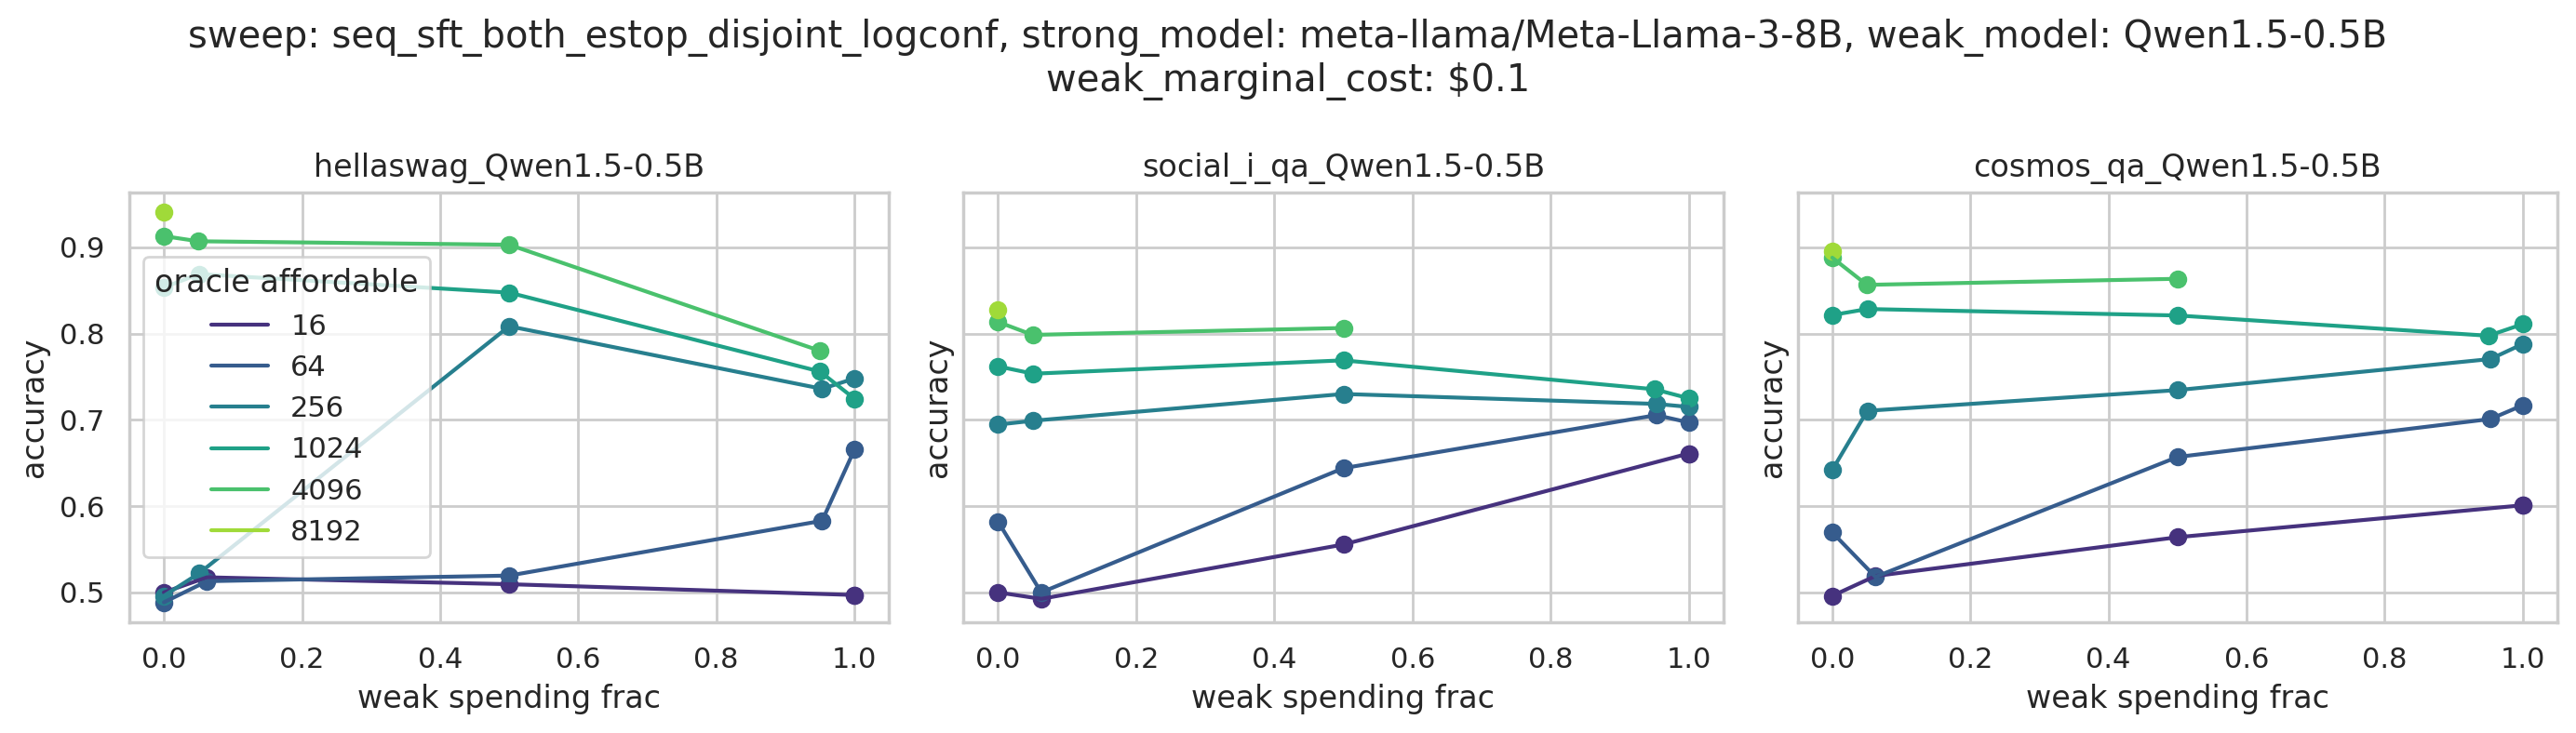

In [5]:
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

weak_marginal_cost = 1/10
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"


sweep_name = "seq_sft_both_estop_disjoint_logconf"
# sweep_name = "oracle_prompted_weak_sft_estop"
# sweep_name = "seq_sft_both_estop_active_oracle_disjoint"
# sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.5, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 1024, 4096, 8192]
current_base_ds_names = ["hellaswag", "social_i_qa", "cosmos_qa"]

# sweep_name = "seq_sft_both_estop_clean_disjoint"
# weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
# oracle_affordables = [8, 16, 64, 256, 512, 1024, 4096, 8192]
# current_base_ds_names = base_ds_names

kinds = ["{base_name}_" + weak_model,]

fig, axs = plt.subplots(len(kinds), len(current_base_ds_names), figsize=(2 + 4 * len(current_base_ds_names), len(kinds) * 4), sharex=True, sharey=True, dpi=200)
axs = axs.reshape((-1, len(current_base_ds_names)))
for i, kind in enumerate(kinds):
    for j, base_ds_name in enumerate(current_base_ds_names):
        plt.sca(axs[i, j])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        # saliences = salience_df.loc[(ds_name, strong_model)]
        # salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]
        
        for oracle_affordable in oracle_affordables:
            accs = []
            actual_wsfs = []
            for wsf in weak_spending_fracs:
                osf = 1 - wsf
                n_oracle = int(wsf * oracle_affordable)
                n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
                acc, acc_std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                if acc is not None:
                    accs.append(acc)
                    actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
                
            plt.plot(actual_wsfs, accs, label=f"{oracle_affordable}")
            plt.scatter(actual_wsfs, accs)
            
        plt.xlabel("weak spending frac")
        plt.ylabel("accuracy")
        plt.title(f"{ds_name}")
        if i == 0 and j == 0:
            plt.legend(title="oracle affordable")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\${weak_marginal_cost}")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1395209/2201615677.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]


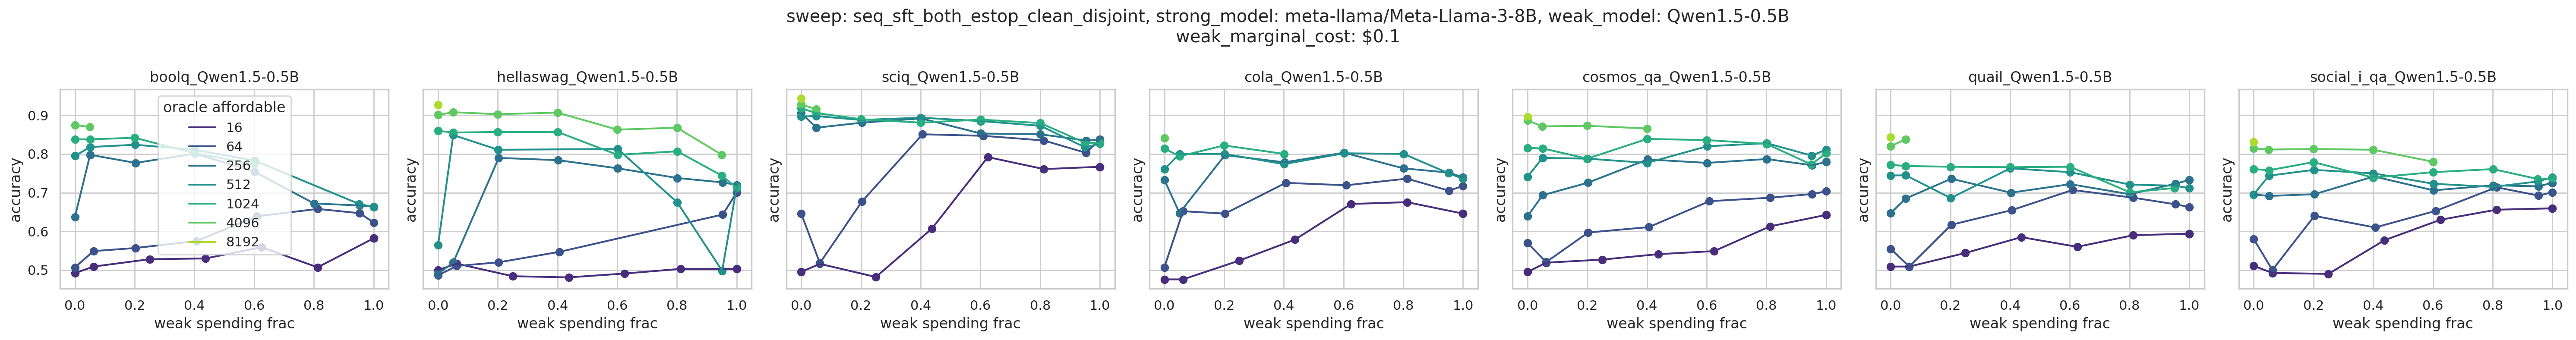

In [6]:
sns.set_theme(style="whitegrid")

weak_marginal_cost = 1/10
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"


sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
sns.set_palette("viridis", n_colors=len(oracle_affordables))
current_base_ds_names = base_ds_names

kinds = ["{base_name}_" + weak_model,]

fig, axs = plt.subplots(len(kinds), len(current_base_ds_names), figsize=(2 + 4 * len(current_base_ds_names), len(kinds) * 4), sharex=True, sharey=True, dpi=200)
axs = axs.reshape((-1, len(current_base_ds_names)))
for i, kind in enumerate(kinds):
    for j, base_ds_name in enumerate(current_base_ds_names):
        plt.sca(axs[i, j])
        ds_name = kind.format(base_name=base_ds_name)
        run_name = (ds_name,
            strong_model,
            sweep_name)
        
        # saliences = salience_df.loc[(ds_name, strong_model)]
        # salience_weak, salience_oracle = saliences["salience_weak"], saliences["salience_oracle"]
        
        for oracle_affordable in oracle_affordables:
            accs = []
            actual_wsfs = []
            for wsf in weak_spending_fracs:
                osf = 1 - wsf
                n_oracle = int(wsf * oracle_affordable)
                n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
                acc, acc_std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                if acc is not None:
                    accs.append(acc)
                    actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
                
            plt.plot(actual_wsfs, accs, label=f"{oracle_affordable}")
            plt.scatter(actual_wsfs, accs)
            
        plt.xlabel("weak spending frac")
        plt.ylabel("accuracy")
        plt.title(f"{ds_name}")
        if i == 0 and j == 0:
            plt.legend(title="oracle affordable")
plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\${weak_marginal_cost}")
plt.tight_layout()
plt.show()

# Results averaged over datasets and seeds

/tmp/ipykernel_1395209/2201615677.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]


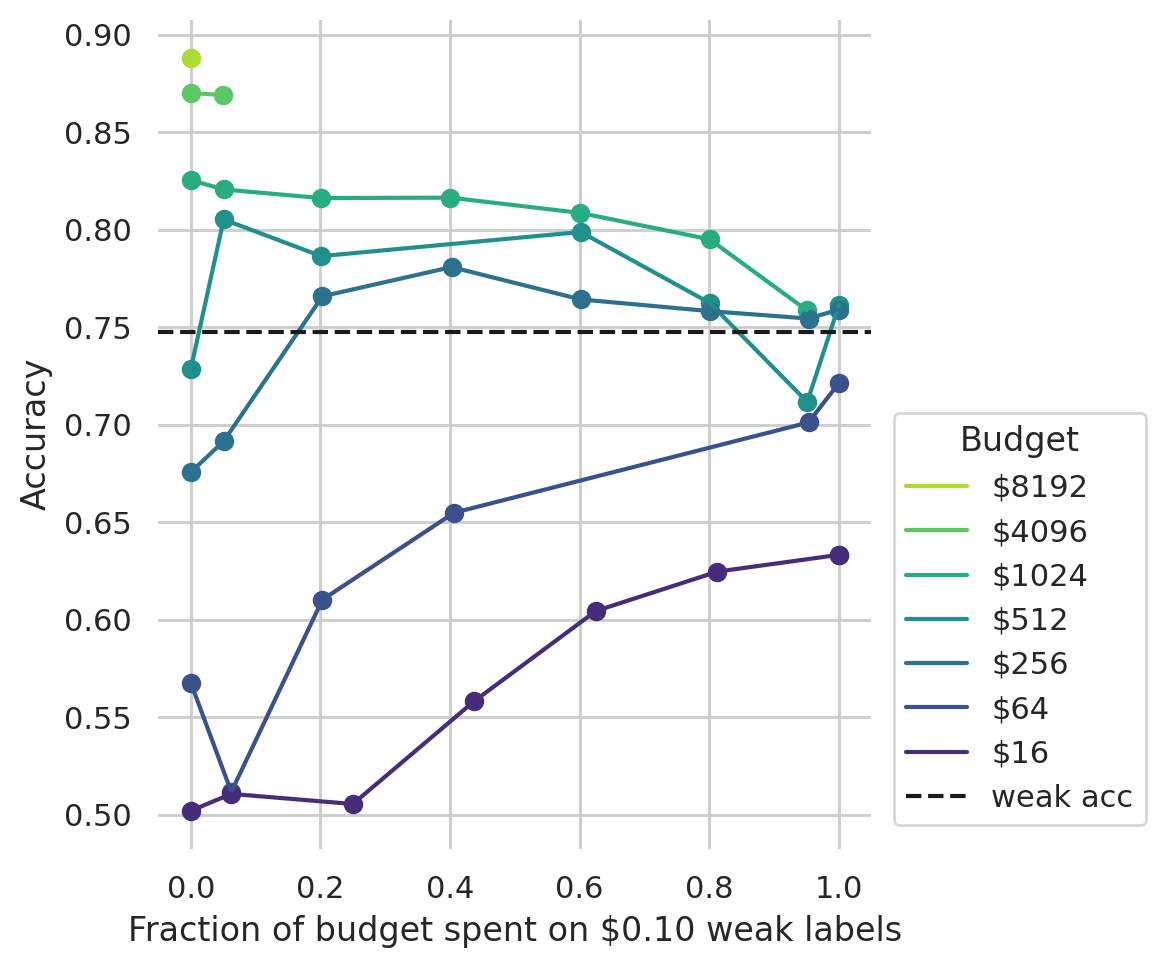

In [7]:
sns.set_theme(style="whitegrid")

metric = "acc"
weak_marginal_cost = 1/10
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"

sweep_name = "seq_sft_both_estop_clean_disjoint"
weak_spending_fracs = [0.0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1.0]
oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
sns.set_palette("viridis_r", n_colors=len(oracle_affordables))
current_base_ds_names = base_ds_names.copy()
current_base_ds_names.remove("boolq")
current_base_ds_names.remove("cola")


kind = "{base_name}_" + weak_model

fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True, sharey=True, dpi=200)
plt.sca(ax)

for oracle_affordable in oracle_affordables[::-1]:
    accs = []
    stds = []
    actual_wsfs = []
    for wsf in weak_spending_fracs:
        osf = 1 - wsf
        n_oracle = int(wsf * oracle_affordable)
        n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
        current_accs = []
        current_stds = []
        for j, base_ds_name in enumerate(current_base_ds_names):
            ds_name = kind.format(base_name=base_ds_name)
            run_name = (ds_name,
                strong_model,
                sweep_name)
            acc, std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False, metric=metric)
            current_accs.append(acc)
            current_stds.append(std)
        if any(ca is None for ca in current_accs):
            continue
        accs.append(np.mean(current_accs))
        stds.append(np.std(current_accs))
        actual_wsfs.append(1 - (n_oracle / (n_oracle + n_weak * weak_marginal_cost)))
        
    plt.plot(actual_wsfs, accs, label=f"\\${oracle_affordable}")
    plt.scatter(actual_wsfs, accs)
    accs, stds = np.array(accs), np.array(stds)
    lo, hi = accs - stds, accs + stds
    # plt.fill_between(actual_wsfs, lo, hi, alpha=0.2)
    # plt.scatter(actual_wsfs[-1:], accs[-1:], s=50, marker="s", zorder=0,)

weak_acc = np.mean([weak_accs[f"{base_name}_{weak_model}"] for base_name in current_base_ds_names])
plt.axhline(weak_acc, color="k", linestyle="--", label=f"weak acc")
    
# turn off axis lines
plt.gca().spines['left'].set_color('none')
plt.gca().spines['bottom'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.xlabel(f"Fraction of budget spent on \\${weak_marginal_cost:.2f} weak labels")
plt.ylabel(metric.replace("calibrated_acc", "Calibrated Accuracy").replace("acc", "Accuracy"))
# plt.title(current_base_ds_names)
plt.legend(title="Budget", loc="lower left", bbox_to_anchor=(1.01, 0.01))
# plt.suptitle(f"sweep: {sweep_name}, strong_model: {strong_model}, weak_model: {weak_model}\nweak_marginal_cost: \\$$_g${weak_marginal_cost:.2f}")
plt.tight_layout()
plt.savefig(f"_figures/acc_vs_spending_frac.pdf", bbox_inches="tight")
plt.show()

# Pareto frontier figure

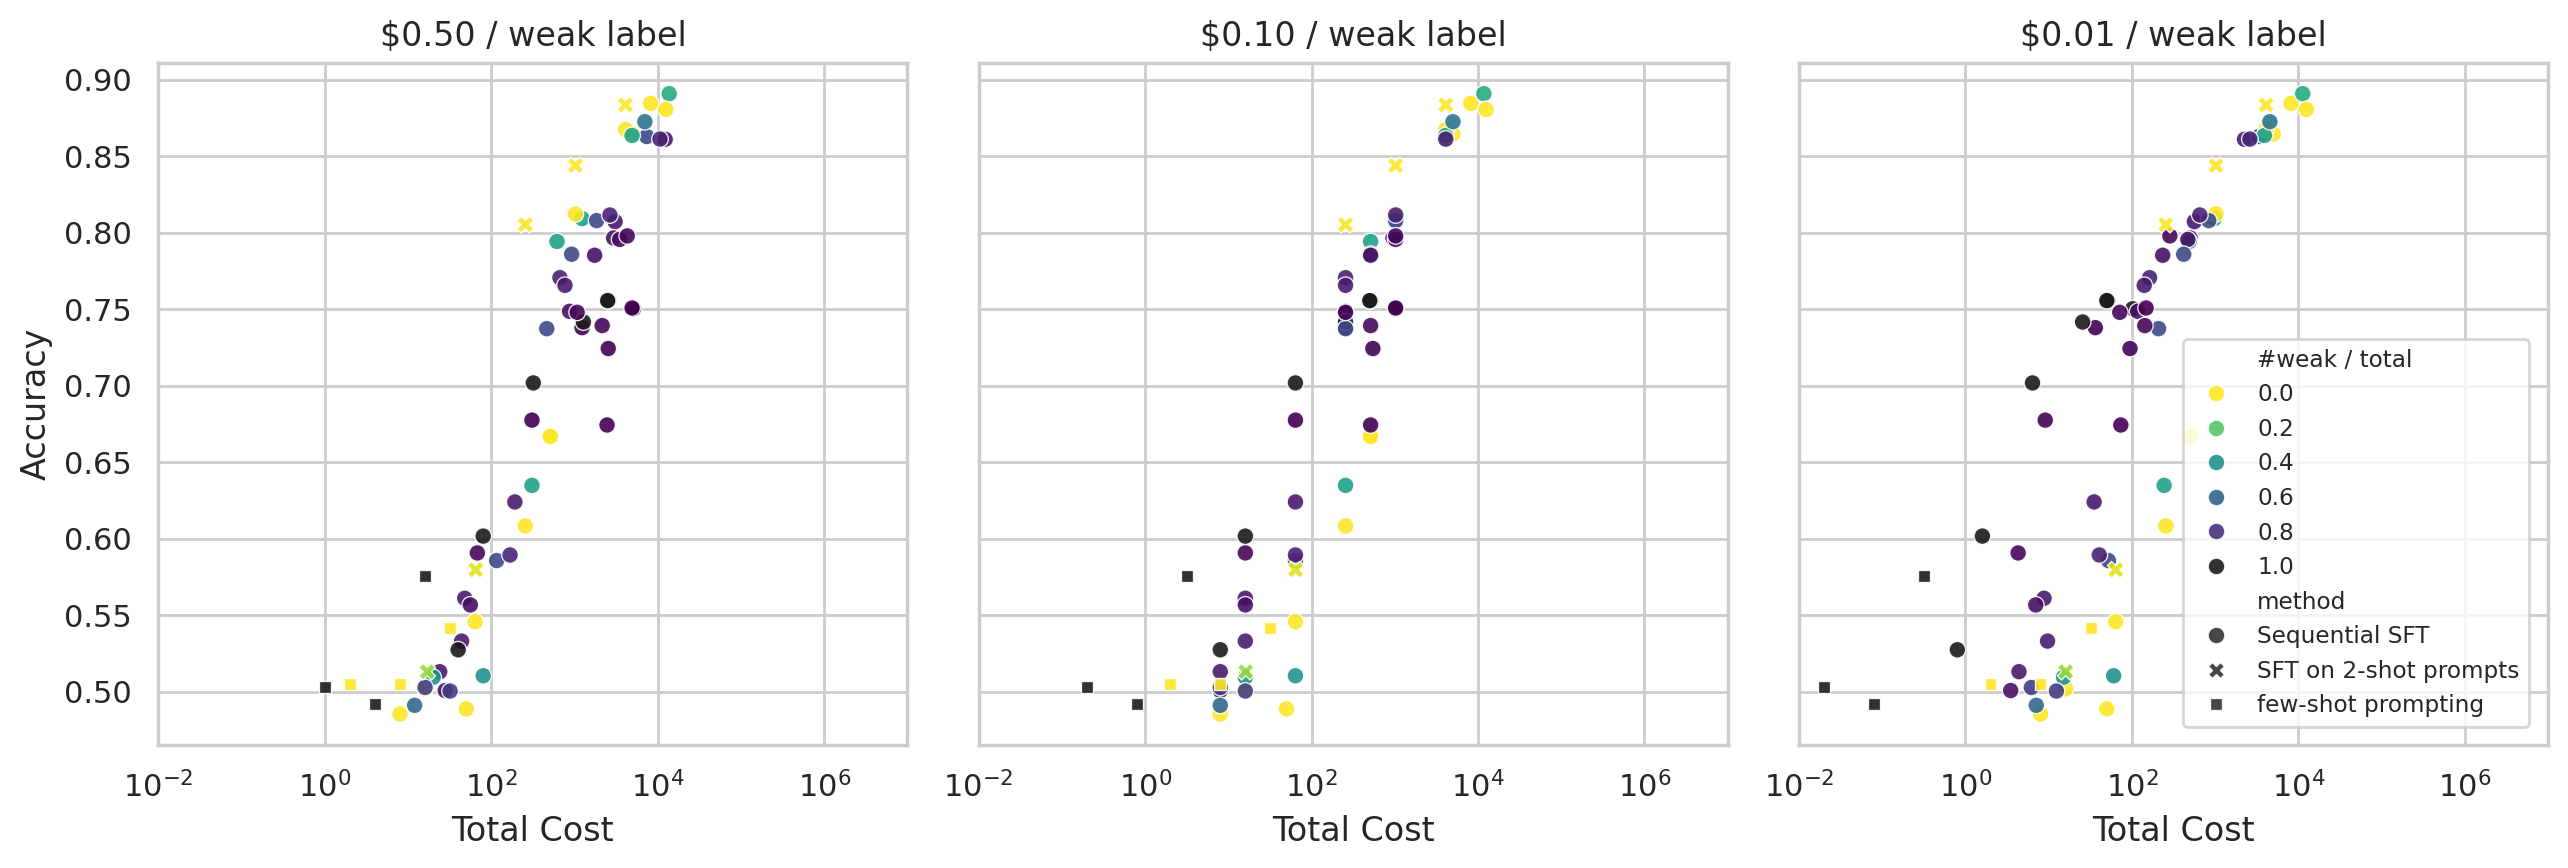

In [26]:
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

metric = "acc"
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"

sweep_names = {
    "seq_sft_both_estop_clean_disjoint": "Sequential SFT",
    # "seq_sft_both_estop_active_oracle_disjoint": "Seq SFT + uncertainty sampling",
    # "seq_sft_both_estop_disjoint_logconf": "Seq SFT + log-confidence",
    "2weak_prompt_oracle_sft_estop": "SFT on 2-shot prompts",
    "few_shot": "few-shot prompting",
}
# weak_spending_fracs = [0.0, 0.05, 0.5, 0.95, 1.0]
# oracle_affordables = [16, 64, 256, 512, 1024, 4096, 8192]
# pairs = []
# for oracle_affordable in oracle_affordables:
#     for wsf in weak_spending_fracs:
#         osf = 1 - wsf
#         n_oracle = int(wsf * oracle_affordable)
#         n_weak = int((oracle_affordable - n_oracle) / weak_marginal_cost)
#         pairs.append((n_weak, n_oracle))

current_ds_names = [f"{base_name}_{weak_model}" for base_name in ["hellaswag", "social_i_qa", "cosmos_qa"]]

weak_marginal_costs = [1/2, 1/10, 1/100]
fig, axs = plt.subplots(1, 3, figsize=(13, 4.5), sharex=True, sharey=True, dpi=200)
for i, weak_marginal_cost in enumerate(weak_marginal_costs):
    ax = axs[i]
    plt.sca(ax)

    dfs = []
    for sweep_name, label in sweep_names.items():
        accs = []

        # get points from first dataset
        ds_name = current_ds_names[0]
        curr_df = results_df.xs((ds_name, strong_model, sweep_name), level=['ds_name', 'model_name', 'sweep_name'])
        # TODO: deduplicate similar n_weak, n_oracle pairs. Or just figure out a better way of plotting alltogether
        perfs = {(n_weak, n_oracle): [] for n_weak, n_oracle in zip(curr_df["num_weak"], curr_df["num_oracle"])}

        for ds_name in current_ds_names:
            run_name = (ds_name,
                strong_model,
                sweep_name)
            for n_weak, n_oracle in perfs:
                acc, std, n = find_result_by_n(results_df, n_weak, n_oracle, run_name, rtol=0.05, verbose=False)
                if acc is not None:
                    perfs[(n_weak, n_oracle)].append(acc)

        nw, no, perf = zip(*[[n_weak, n_oracle, np.mean(perfs[(n_weak, n_oracle)])] for n_weak, n_oracle in perfs if len(perfs[(n_weak, n_oracle)]) == len(current_ds_names)])
        
        df = pd.DataFrame({"nw": nw, "no": no, metric: perf})
        df["cost"] = df["nw"] * weak_marginal_cost + df["no"]
        df["weak_spending_frac"] = df["nw"] * weak_marginal_cost / df["cost"]
        df["#weak / total"] = df["nw"] / (df["nw"] + df["no"])
        df["method"] = label
        dfs.append(df)
        
    # Create the scatter plot
    from matplotlib.colors import FuncNorm
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np

    hue = "#weak / total"
    df = pd.concat(dfs)
    palette = plt.get_cmap('viridis_r').copy()
    palette.set_over('k')
    # Create a new colormap that maps 1.0 to black


    norm = FuncNorm((lambda x: np.log(np.array(x) + 1).tolist(), lambda x: (np.exp(np.array(x)) - 1).tolist()), vmin=0, vmax=df[hue].max() - 1e-6)
    sns.scatterplot(data=df, x='cost', y=metric, hue=hue, alpha=0.9,
                            style='method', palette=palette, ax=ax, hue_norm=norm)

    ax.set_xlim(10**-2, 10**7)
    # ax.invert_xaxis()
    ax.set_xlabel('Total Cost')
    ax.set_ylabel(metric.replace("calibrated_acc", "Calibrated Accuracy").replace("acc", "Accuracy"))
    plt.semilogx()
    if i == 2:
        ax.legend(bbox_to_anchor=(.99, 0.01), loc='lower right', fontsize='x-small')
    else:
        ax.legend().remove()
    plt.title(f"\\${weak_marginal_cost:.2f} / weak label" )
plt.tight_layout()
plt.savefig(f"_figures/pareto_frontier.pdf", bbox_inches="tight")
plt.show()


In [9]:
palette(0.999)

(0.267004, 0.004874, 0.329415, 1.0)

Color at 0.998: (0.267004, 0.004874, 0.329415, 1.0)
Color at 0.999: (0.267004, 0.004874, 0.329415, 1.0)
Color at 0.9999: (0.267004, 0.004874, 0.329415, 1.0)
Color at 1.0: [0, 0, 0, 1]


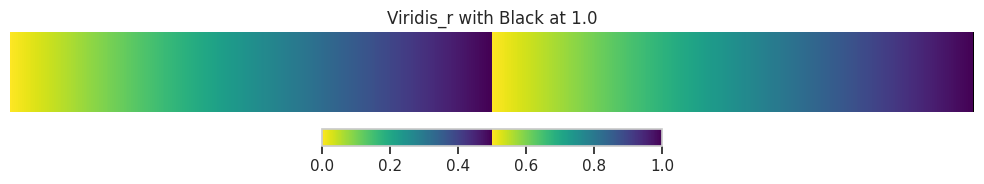

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def viridis_r_black(x):
    viridis_r = plt.get_cmap('viridis_r')
    
    if np.isscalar(x):
        return [0,0,0,1] if x == 1 else viridis_r(x)
    else:
        rgba = viridis_r(x)
        rgba[x == 1] = [0,0,0,1]
        return rgba

# Test the new colormap function
print("Color at 0.998:", viridis_r_black(0.998))
print("Color at 0.999:", viridis_r_black(0.999))
print("Color at 0.9999:", viridis_r_black(0.9999))
print("Color at 1.0:", viridis_r_black(1.0))

# Visualize the colormap
fig, ax = plt.subplots(figsize=(10, 2))
gradient = np.linspace(0, 1, 1000)
gradient = np.vstack((gradient, gradient))

# Use our custom function to create colors for imshow
colors = viridis_r_black(gradient)

im = ax.imshow(gradient, aspect='auto', cmap=ListedColormap(colors.reshape(-1, 4)))
ax.set_axis_off()
plt.colorbar(im, ax=ax, orientation='horizontal', aspect=20)
plt.title('Viridis_r with Black at 1.0')
plt.tight_layout()
plt.show()

# Few shot vs sft

n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=1
n=1
n=1
n=0
n=1
n=1
n=1
n=0
n=0
n=0
n=0
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=0
n=1
n=0
n=1
n=0
n=1
n=1
n=1
n=1
n=1


/tmp/ipykernel_1395209/2201615677.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]
/tmp/ipykernel_1395209/2201615677.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]
/tmp/ipykernel_1395209/2201615677.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]
/tmp/ipykernel_1395209/2201615677.py:86: PerformanceWarning: indexing past lexsort depth may impact performance.
  curr_df = results_df.loc[run_name]


n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=0
n=1
n=0
n=1
n=0
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=0
n=1
n=1
n=1
n=1
n=1
n=1
n=0
n=1
n=0
n=0
n=0
n=0


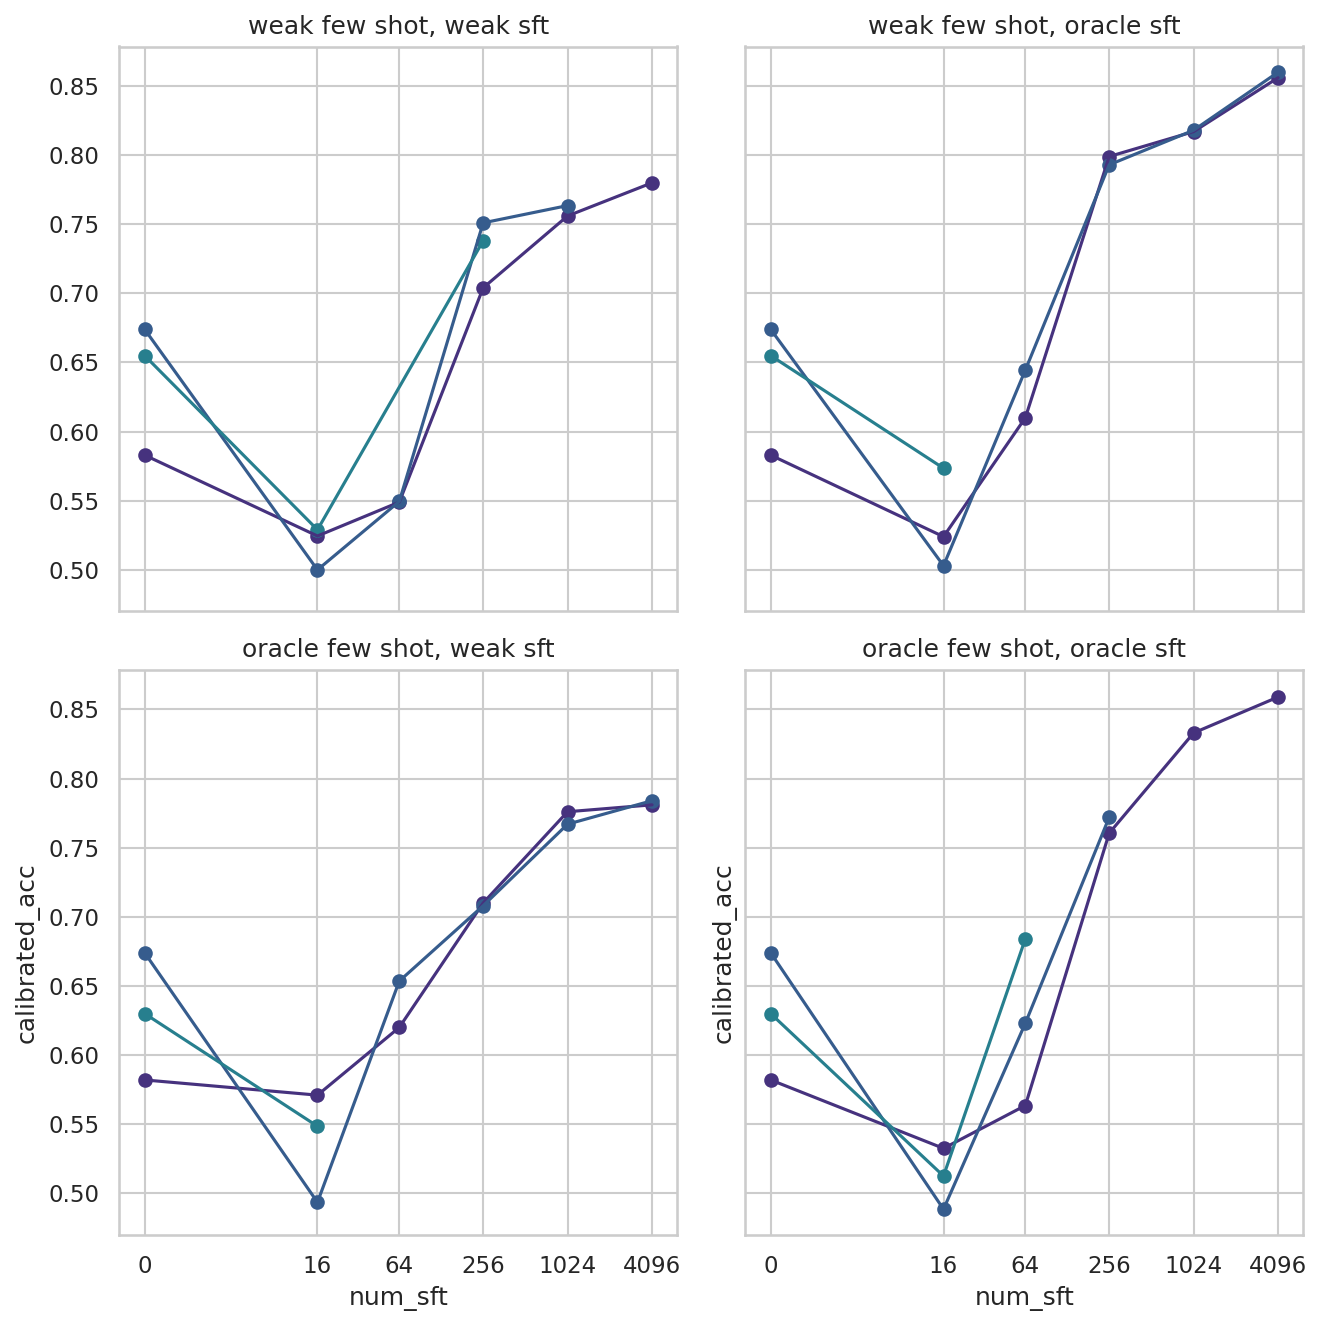

In [11]:
from collections import defaultdict

metric = "calibrated_acc"
weak_model = "Qwen1.5-0.5B"
strong_model = "meta-llama/Meta-Llama-3-8B"

current_ds_names = [f"{name}_{weak_model}" for name in ["cosmos_qa", "social_i_qa"]]
num_sfts = [0, 16, 64, 256, 1024, 4096]

fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True, dpi=150)
for i, few_shot_type in enumerate(["weak", "oracle"]):
    for j, sft_type in enumerate(["weak", "oracle"]):
        plt.sca(axs[i, j])
        for num_few_shot in [2, 8, 32]:
            accs = []
            plotted_num_sfts = []
            for num_sft in num_sfts:
                nums = defaultdict(int)
                nums[sft_type] += num_sft
                nums[few_shot_type] += num_few_shot

                if num_sft == 0:
                    sweep_name = "few_shot"
                else:
                    sweep_name = f"{num_few_shot}{few_shot_type}_prompt_{sft_type}_sft_estop"

                current_accs = []
                for j, ds_name in enumerate(current_ds_names):
                    run_name = (
                        ds_name,
                        strong_model,
                        sweep_name
                    )
                    acc, acc_std, n = find_result_by_n(results_df, nums["weak"], nums["oracle"], run_name, rtol=0.05, verbose=False, metric=metric)
                    print(f"{n=}")
                    current_accs.append(acc)
                if any(ca is None for ca in current_accs):
                    continue
                accs.append(np.mean(current_accs))
                plotted_num_sfts.append(num_sft)
            
            lp1_num_sfts = np.log2(np.array(plotted_num_sfts) + 1)
            plt.plot(lp1_num_sfts, accs, label=f"{num_few_shot}")
            plt.scatter(lp1_num_sfts, accs)

        x_locs = np.log2(np.array(num_sfts) + 1)
        x_labels = [str(round(2**x) - 1) for x in x_locs]
        plt.xticks(x_locs, x_labels)
        plt.gca().set_xticklabels(x_labels)
        plt.title(f"{few_shot_type} few shot, {sft_type} sft")
        if i == 1 and j == 1:
            plt.xlabel("num_sft")
            plt.ylabel(metric)
plt.tight_layout()
plt.show()
    

In [12]:
results_df["sweep_name"].unique()

array(['seq_sft_both_estop_clean_disjoint',
       'seq_sft_both_estop_clean_long', 'few_shot_prompt',
       'few_shot_prompted_sft_estop', '2oracle_prompt_weak_sft_estop',
       'seq_sft_both_estop_disjoint_logconf',
       'seq_sft_both_estop_active_oracle_disjoint',
       '8oracle_prompt_oracle_sft_estop',
       '2oracle_prompt_oracle_sft_estop', '2weak_prompt_oracle_sft_estop',
       'weak_prompted_oracle_sft_estop', 'oracle_prompted_weak_sft_estop',
       '8weak_prompt_oracle_sft_estop', 'few_shot',
       '8oracle_prompt_weak_sft_estop', '8weak_prompt_weak_sft_estop',
       '2weak_prompt_weak_sft_estop', 'seq_sft_both_estop_clean',
       '32oracle_prompt_oracle_sft_estop', '32weak_prompt_weak_sft_estop',
       '32weak_prompt_oracle_sft_estop', '32oracle_prompt_weak_sft_estop'],
      dtype=object)

In [13]:
results_df.xs("weak_prompted_oracle_sft_estop", level="sweep_name")

auroc    acc  \
ds_name                  model_name                                    
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  0.507368  0.510   
                         meta-llama/Meta-Llama-3-8B  0.489983  0.491   
                         meta-llama/Meta-Llama-3-8B  0.519656  0.491   
                         meta-llama/Meta-Llama-3-8B  0.480284  0.491   
                         meta-llama/Meta-Llama-3-8B  0.499490  0.511   
...                                                       ...    ...   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B  0.548760  0.510   
                         meta-llama/Meta-Llama-3-8B  0.511529  0.490   
                         meta-llama/Meta-Llama-3-8B  0.488639  0.498   
                         meta-llama/Meta-Llama-3-8B  0.480656  0.490   
                         meta-llama/Meta-Llama-3-8B  0.691529  0.642   

                                                     calibrated_acc  \
ds_name                  model_name                                   
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B           0.500   
                         meta-llama/Meta-Llama-3-8B           0.505   
                         meta-llama/Meta-Llama-3-8B           0.515   
                         meta-llama/Meta-Llama-3-8B           0.474   
                         meta-llama/Meta-Llama-3-8B           0.497   
...                                                             ...   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B           0.538   
                         meta-llama/Meta-Llama-3-8B           0.491   
                         meta-llama/Meta-Llama-3-8B           0.492   
                         meta-llama/Meta-Llama-3-8B           0.476   
                         meta-llama/Meta-Llama-3-8B           0.658   

                                                                     model_name  \
ds_name                  model_name                                               
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
...                                                                         ...   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   

                                                     num_oracle  num_weak  \
ds_name                  model_name                                         
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B         256         0   
                         meta-llama/Meta-Llama-3-8B          64         0   
                         meta-llama/Meta-Llama-3-8B          16         0   
                         meta-llama/Meta-Llama-3-8B         256         0   
                         meta-llama/Meta-Llama-3-8B          64         0   
...                                                         ...       ...   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B          15        10   
                         meta-llama/Meta-Llama-3-8B          15        10   
                         meta-llama/Meta-Llama-3-8B           8         0   
                         meta-llama/Meta-Llama-3-8B           7        10   
                         meta-llama/Meta-Llama-3-8B         256         0   

                                                     num_oracle_nonunique  \
ds_name                  model_name 

In [14]:
results_df.xs("oracle_prompted_weak_sft_estop", level="sweep_name")

auroc    acc  \
ds_name                  model_name                                    
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  0.506576  0.509   
                         meta-llama/Meta-Llama-3-8B  0.545701  0.534   
                         meta-llama/Meta-Llama-3-8B  0.975892  0.915   
                         meta-llama/Meta-Llama-3-8B  0.518144  0.509   
                         meta-llama/Meta-Llama-3-8B  0.541884  0.524   
                         meta-llama/Meta-Llama-3-8B  0.477863  0.512   
                         meta-llama/Meta-Llama-3-8B  0.522413  0.507   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  0.768956  0.696   
                         meta-llama/Meta-Llama-3-8B  0.671190  0.624   
                         meta-llama/Meta-Llama-3-8B  0.506767  0.513   
                         meta-llama/Meta-Llama-3-8B  0.571963  0.515   
                         meta-llama/Meta-Llama-3-8B  0.550752  0.513   
                         meta-llama/Meta-Llama-3-8B  0.581257  0.513   
                         meta-llama/Meta-Llama-3-8B  0.950030  0.873   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B  0.730500  0.657   
                         meta-llama/Meta-Llama-3-8B  0.755806  0.692   
                         meta-llama/Meta-Llama-3-8B  0.500188  0.501   
                         meta-llama/Meta-Llama-3-8B  0.511757  0.507   
                         meta-llama/Meta-Llama-3-8B  0.477579  0.510   
                         meta-llama/Meta-Llama-3-8B  0.503786  0.500   
                         meta-llama/Meta-Llama-3-8B  0.918700  0.846   
                         meta-llama/Meta-Llama-3-8B  0.489112  0.508   
                         meta-llama/Meta-Llama-3-8B  0.475978  0.490   

                                                     calibrated_acc  \
ds_name                  model_name                                   
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B           0.500   
                         meta-llama/Meta-Llama-3-8B           0.532   
                         meta-llama/Meta-Llama-3-8B           0.916   
                         meta-llama/Meta-Llama-3-8B           0.512   
                         meta-llama/Meta-Llama-3-8B           0.535   
                         meta-llama/Meta-Llama-3-8B           0.474   
                         meta-llama/Meta-Llama-3-8B           0.508   
cosmos_qa_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B           0.690   
                         meta-llama/Meta-Llama-3-8B           0.630   
                         meta-llama/Meta-Llama-3-8B           0.496   
                         meta-llama/Meta-Llama-3-8B           0.548   
                         meta-llama/Meta-Llama-3-8B           0.551   
                         meta-llama/Meta-Llama-3-8B           0.552   
                         meta-llama/Meta-Llama-3-8B           0.880   
social_i_qa_Qwen1.5-0.5B meta-llama/Meta-Llama-3-8B           0.664   
                         meta-llama/Meta-Llama-3-8B           0.684   
                         meta-llama/Meta-Llama-3-8B           0.487   
                         meta-llama/Meta-Llama-3-8B           0.511   
                         meta-llama/Meta-Llama-3-8B           0.478   
                         meta-llama/Meta-Llama-3-8B           0.513   
                         meta-llama/Meta-Llama-3-8B           0.838   
                         meta-llama/Meta-Llama-3-8B           0.502   
                         meta-llama/Meta-Llama-3-8B           0.483   

                                                                     model_name  \
ds_name                  model_name                                               
hellaswag_Qwen1.5-0.5B   meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/Meta-Llama-3-8B   
                         meta-llama/Meta-Llama-3-8B  meta-llama/